## Mathematical Principles in Pattern Recognition (2017/2018)
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bA}{\mathbf{A}}$
$\newcommand{\bQ}{\mathbf{Q}}$
$\newcommand{\bR}{\mathbf{R}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bSigma}{\boldsymbol{\Sigma}}$
$\newcommand{\bmu}{\boldsymbol{\mu}}$
$\newcommand{\bpi}{\boldsymbol{\pi}}$

# Lab 3

In the computer labs we will work with the Python programming language within a Jupyter notebook. Each week a new notebook is made available that contains the exercises that are to be handed-in. 

* It is expected that you work in pairs but individual submissions are allowed.
* Only one of each pair has to submit on blackboard. Make sure that you add the student ID of your partner in the submission comments.
* The main notebook file you submit should read "Lab[number]_[last name 1]_[last name 2].ipynb", for example "Lab2_Bongers_Versteeg.ipynb". 
* Please make sure your code will run without problems!

Feel free ask any questions during the computer lab sessions, or email the TA, Elise (e.e.vanderpol@uva.nl).

**The due date for the labs is Friday, Sep 29 at 15:00**

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1 Maximum likelihood estimation
In this exercise, our goal is to use maximum likelihood estimation with gradient descent to estimate the probability density by using of a set of  samples drawn from a multivariate Gaussian. 

Note: even though there exists a close form solution for this case, we will go the academic route and use numerical optimization anyway.

### 1.1 Multivariate Gaussian
**[5 points]** Draw 250 samples from a multivariate Gaussian with parameters
$$
\bmu =
\begin{pmatrix}
        0.3 \\
        -1.8 \\
\end{pmatrix}\mathrm{;\ }
\bSigma =
\begin{pmatrix}
        2.1 & 1.3 \\
        1.3 & 4.9 \\
\end{pmatrix}\mathrm{;\ }
$$
and make a scatterplot of the result.

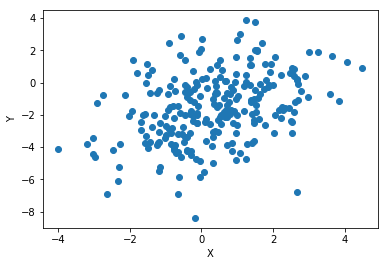

In [3]:

# Makes sure that we always get the same random data
np.random.seed(4294967295)

# Params
n = 250
mu = np.array([0.3, -1.8])
sigma = np.array([[2.1, 1.3], [1.3, 4.9]])

# Multivariate gaussian
data = np.random.multivariate_normal(mu, sigma, n)

# Scatterplot
plt.scatter(data[:, 0], data[:, 1])
plt.ylabel('Y')
plt.xlabel('X')
plt.show()


### 1.2 Log likelihood
**[15 points]** Write down the log likelihood of this two-dimensional Gaussian model and write a function `loglik(data, mu, sigma)` that returns the log likelihood for the data that it is given. (We will use this later.)

Log likelihood: 

In [4]:

# Log likelihood
def loglik(data, mu, sigma):
    N = len(data)
    D = len(data[0])
    ln_pi = np.log(2 * math.pi)
    ln_sigma = np.log(np.linalg.det(sigma))
    first_half = -(N * D * ln_pi) /2 - (N * ln_sigma) /2
    
    sec_half = 0.0
    inv_sigma = np.linalg.inv(sigma)
    for line in data:
        m_t = np.matmul(np.transpose(line - mu), inv_sigma)
        sec_half += float(np.matmul(m_t, (line - mu)))
    sec_half = sec_half /-2
    
    return first_half + sec_half

loglik(data, mu, sigma)

-982.21830332632112

### 1.3 Gradients
**[15 points]** Write down the gradient of the log likelihood with respect to $\boldsymbol{\mu}$, we already provided the gradient w.r.t. $\bSigma$ below:
$$
\nabla_{\bSigma} (\log \mathcal{L}) = - \frac{n}{2} \bSigma^{-1} + \frac{n}{2} \bSigma^{-1} \boldsymbol{S} \bSigma^{-1}\mathrm{,}
$$
where $\boldsymbol{S} = \frac{1}{n} \sum_i^n (\bx_i- \bmu)(\bx_i- \bmu)^T$. (if you like to derive it as an exercise, feel free to do so.)

Write a function `grad_loglik(x, mu, sigma)` that returns the gradients as evaluated on the data set `x`. 

[your answer here]

In [5]:

def grad_loglik_sigma(x, mu, sigma):
    inv_sigma = np.linalg.inv(sigma)
    N = len(x)
    first_half = -N * inv_sigma/2
    
    S = np.matmul(np.transpose(x - mu.T), (x - mu.T)) / N
    sec_half = np.matmul(N * inv_sigma / 2, np.matmul(S, inv_sigma))
    return first_half + sec_half

def grad_loglik_mu(x, mu, sigma):
    inv_sigma = np.linalg.inv(sigma)
    value = array([[0.0], [0.0]])
    for line in x:
        value += np.transpose(np.matmul(line - mu.T, inv_sigma))
    return value

def grad_loglik(x, mu, sigma):
    return grad_loglik_mu(x, mu, sigma), grad_loglik_sigma(x, mu, sigma)


### 1.4 Numerical optimization
**[35 points]** Numerically compute maximum likelihood estimates of all parameters. Implement the gradient ascent (or descent, https://en.wikipedia.org/wiki/Gradient_descent) numerical optimization method, by using the functions you created in 1.2 and 1.3. I.e. after initializing all parameters to reasonable values, repeat:
* calculate gradients for the data 
* update the parameters with the gradients and an appropriate learning rate

Keep track of the log likelihood after each step and make a plot of this. 
Run it for several iterations and visualize the resulting distribution with the data in the same figures (either 2 1D projections or a fancy 2D plot is accepted)

In [28]:

# From calculation, it is expected that the local minimum occurs at x=9/4

cur_mu = (np.random.ranf((2, 1)) - 0.5) * random.uniform(0.0, 10.0)
cur_sigma = (np.random.ranf((2, 2)) - 0.5) * random.uniform(0.0, 10.0)
gamma = 0.01 # step size multiplier
precision = 0.01
previous_step_size_mu = abs(sum(cur_mu))
previous_step_size_sigma = abs(sum(cur_sigma))
mu_plot = []
sigma_plot = []

while previous_step_size_mu > precision or previous_step_size_sigma > precision:
    prev_mu, prev_sigma = copy(cur_mu), copy(cur_sigma)
    if previous_step_size_mu > precision:
        cur_mu += -gamma * grad_loglik_mu(samples, prev_mu, prev_sigma)
        previous_step_size_mu = sum(abs(cur_mu - prev_mu))
        mu_plot.append(previous_step_size_mu)
    
    if previous_step_size_sigma > precision:
        cur_sigma += -gamma * grad_loglik_sigma(samples, prev_mu, prev_sigma)
        previous_step_size_sigma = sum(abs(cur_sigma - prev_sigma))
        sigma_plot.append(previous_step_size_sigma)

print("min mean:", cur_mu, "min covariance", cur_sigma)


min mean: [[ 0.35473958]
 [-2.08393682]] min covariance [[-240.44845371    1.29614473]
 [  -3.83094091 -274.09542798]]


## 2. Nonparametric density estimation
Up to now we have used parametric models for (density) estimation. One example of a nonparametric method we used earlier is the (normalized) histogram method, with fixed binning. We will explore an example of a  nonparametric method: kernel density estimation.

Consider the data loaded below, which is drawn from a mixture of 3 Gaussians.

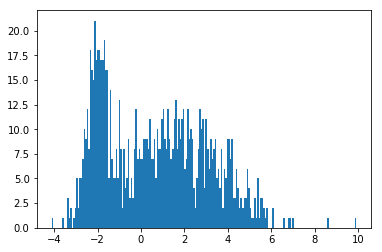

In [21]:

import _pickle as cPickle
with open('assets/mixture.pkl', 'rb') as f:
    mixed_data = cPickle.load(f, encoding='latin1')
_ = plt.hist(mixed_data, 200)


### 2.1 Histograms

**[10 points]** Using the `mixed_data` above, illustrate two potential disadvantages of the histogram method as a nonparametric method for density estimation.

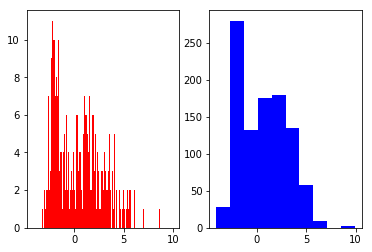

In [22]:

# Create two subplots
fig, axs = plt.subplots(1, 2, sharey=False)

axs[0].hist(mixed_data, 500, fc='r')
axs[1].hist(mixed_data, 10, fc='b')
plt.show()

# Zie hoe de data bij 0 > x > 5 varieerd in de linker histogram, maar heel 
# 'dense' wordt getoond in de rechter histogram. Twee representaties van 
# dezelfde data kunnen te precies, of te grof zijn wat kan leiden tot 
# verschillende interpretaties van de data.


### 2.2 Kernel density approximation
**[20 points]** One other way to estimate the density given some data sample, is by using kernels. A kernel $f_h(x)$ is a function of the data, given some smoothing parameter $h$, that specifies the local neighbourhood around a point. (See Bishop 2.5.2 or Hastie 2.8.2 or Google). 

Specify pros and cons of KDE over the histogram method by creating plots of the `mixed_data` above. Use in your arguments one or two different kernels with one or two different bandwidths. You are allowed to use a KDE code from whatever python package you prefer, for example `sklearn` or `statsmodels`.

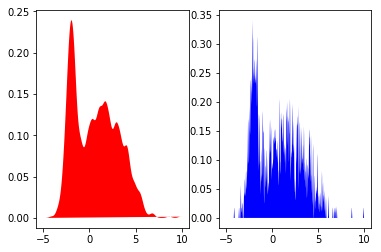

In [23]:

from sklearn.neighbors.kde import KernelDensity

# Setup
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
mixed_data_newaxis = mixed_data[:, np.newaxis]
fig, axs = plt.subplots(1, 2, sharey=False)

# Gaussian KDA
kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(mixed_data_newaxis)
gaussian = kde.score_samples(X_plot)
axs[0].fill(X_plot[:, 0], np.exp(gaussian), fc='r')

# Linear KDA
kde = KernelDensity(kernel='linear', bandwidth=0.05).fit(mixed_data_newaxis)
exponential = kde.score_samples(X_plot)
axs[1].fill(X_plot[:, 0], np.exp(exponential), fc='b')
plt.show()

# Met KDA kan de density op een overzichtelijkere manier weergegeven worden
# waarbij binning minder invloed heeft op het resultaat.
# Een nadeel van KDA t.o.v. een histogram is dat zero values niet zichtbaar
# zijn als ze naast nonzero values liggen.
